# Gaussian splats

## 2D Gaussian

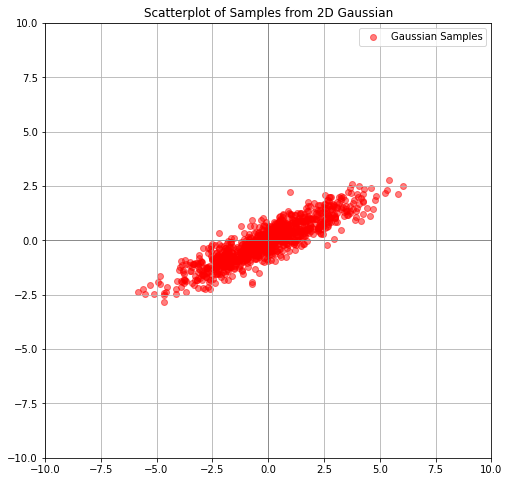

In [427]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_gaussian_samples(mu, cov, num_samples=500, ax=None, color='blue', label=''):
    samples = np.random.multivariate_normal(mu, cov, num_samples)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.5, c=color, label=label)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.axhline(0, color='grey', lw=0.8)
    ax.axvline(0, color='grey', lw=0.8)
    ax.grid(True)
    ax.legend()
    ax.set_title('Scatterplot of Samples from 2D Gaussian')
    return ax

mu = np.array([0, 0])
cov = np.array([[4, 1.8], [1.8, 1]])  # Positive correlation example

fig, ax = plt.subplots(figsize=(8, 8))
plot_gaussian_samples(mu, cov, num_samples=1000, ax=ax, color='red', label='Gaussian Samples')
plt.show()


[0.5 4. ]


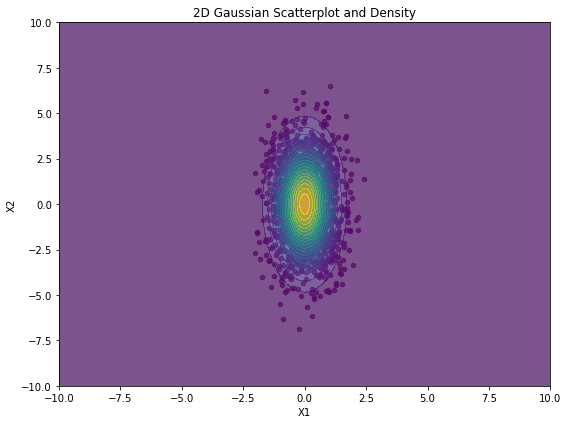

In [428]:
# Mean and covariance for 2D Gaussian
mu = np.array([0, 0])
cov = np.array([[0.5, 0],
                [0, 4]])

print(np.linalg.eigvals(cov))
# Generate random samples
num_samples = 2000
samples = np.random.multivariate_normal(mu, cov, num_samples)

# Scatter plot of the samples
plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=20, color='purple', alpha=0.7)

# Overlay density contours (heatmap)
x = np.linspace(-10, 10, 300)
y = np.linspace(-10, 10, 300)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
rv = multivariate_normal(mu, cov)
Z = rv.pdf(pos)

plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)

plt.title("2D Gaussian Scatterplot and Density")
plt.xlabel("X1")
plt.ylabel("X2")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.tight_layout()
plt.show()


## 3D Gaussian Splats

In [429]:
import plotly.graph_objects as go

mu = np.array([0, 0, 0])
cov = np.array([[4, 1, 0.5],
                [1, 2, 0.2],
                [0.5, 0.2, 3]])
n_points = 50

eigvals, eigvecs = np.linalg.eigh(cov)

# Generate data for unit sphere
u = np.linspace(0, 2 * np.pi, n_points)
v = np.linspace(0, np.pi, n_points)

x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones_like(u), np.cos(v))

# Scale and rotate the sphere to match Gaussian ellipsoid
radii = np.sqrt(eigvals)
ellipsoid = np.array([x.flatten(), y.flatten(), z.flatten()])
scaled = np.dot(np.diag(radii), ellipsoid)
rotated = np.dot(eigvecs, scaled).T
x_ellip = rotated[:, 0].reshape(n_points, n_points) + mu[0]
y_ellip = rotated[:, 1].reshape(n_points, n_points) + mu[1]
z_ellip = rotated[:, 2].reshape(n_points, n_points) + mu[2]

# Plot with Plotly
fig = go.Figure(data=[go.Surface(x=x_ellip, y=y_ellip, z=z_ellip, opacity=0.7, colorscale='Viridis')])
fig.update_layout(title='3D Gaussian Ellipsoid', scene=dict(aspectmode='data'))
fig.show()


### Finding Normals from Gaussian Covariances

In [430]:
import numpy as np

def gaussian_normals_from_covariances(means, covariances):
    """
    means: (N, 3) array of Gaussian centers (not used for normals, but often stored together)
    covariances: (N, 3, 3) array of covariance matrices
    returns: (N, 3) array of per-Gaussian normals
    """
    N = covariances.shape[0]
    normals = np.zeros((N, 3))

    for i in range(N):
        Sigma = covariances[i]

        # Eigen-decomposition of covariance
        eigvals, eigvecs = np.linalg.eigh(Sigma)  # eigvals sorted ascending
        print(eigvals)

        # Smallest eigenvalue -> shortest axis -> normal direction
        smallest_idx = np.argmin(eigvals)
        n = eigvecs[:, smallest_idx]

        # Normalize to unit length
        n = n / np.linalg.norm(n)
        normals[i] = n

    return normals

# Example: 3 Gaussians
means = np.array([
    [0.0, 0.0, 0.0],
    [1.0, 1.0, 0.0],
    [0.0, 2.0, 1.0],
])

covariances = np.array([
    # Roughly disk in XY plane -> normal ~ Z
    [[0.05, 0.00, 0.00],
     [0.00, 0.05, 0.00],
     [0.00, 0.00, 0.001]],

    # Tilted ellipsoid
    [[0.02, 0.01, 0.00],
     [0.01, 0.05, 0.01],
     [0.00, 0.01, 0.001]],

    # Another random positive-definite covariance
    [[0.03, 0.00, 0.01],
     [0.00, 0.04, 0.01],
     [0.01, 0.01, 0.002]],
])

normals = gaussian_normals_from_covariances(means, covariances)
print("Per-Gaussian normals:\n", normals)


[0.001 0.05  0.05 ]
[-0.00115393  0.01741453  0.05473941]
[-0.00331091  0.03230889  0.04300202]
Per-Gaussian normals:
 [[ 0.          0.          1.        ]
 [ 0.09904958 -0.20952882  0.97277277]
 [-0.28074278 -0.21592244  0.93517966]]


### Parsing Data

In [431]:
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.transform import Rotation as Rscipy
import trimesh
import open3d as o3d

In [432]:
def load_colmap_datatxt(filepath):
    points = []
    colors = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.startswith('#'):  # skip comment lines
                continue
            parts = line.strip().split()
            if len(parts) < 4:
                continue
            # Parse 3D coordinates from columns 1,2,3 (X,Y,Z)
            x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
            r, g, b = int(parts[4]), int(parts[5]), int(parts[6])
            
            points.append([x, y, z])
            colors.append([r, g, b])
    points = np.array(points)
    colors = np.array(colors)
    return points, colors

def load_objaverse(filepath, sample_multiplier = 10):
    mesh = trimesh.load(filepath).to_mesh()
    mesh.visual = mesh.visual.to_color()
    # sample_points, _, colors = trimesh.sample.sample_surface(mesh, len(mesh.vertices)*sample_multiplier, sample_color=True)
    sample_points = mesh.vertices
    colors = mesh.visual.vertex_colors
    return np.array(sample_points.tolist()), np.array(colors.tolist())[:, :3]


In [433]:
def rgb2sh(colors):
    # C0 = 0.28209479177387814
    return (colors - 0.5) / 0.28209479177387814

def rotation_from_normal(n):
    n = n / (np.linalg.norm(n) + 1e-8)
    z = n 

    x = np.array([1.0, 0.0, 0.0])
    if abs(np.dot(x, z)) > 0.9:
        x = np.array([0.0, 1.0, 0.0])

    x = x - np.dot(x, z) * z
    x /= (np.linalg.norm(x) + 1e-8)

    y = np.cross(z, x)

    R = np.stack([x, y, z], axis=1)
    return R

def initialize_gaussian_from_points(points3d_file):
    # gaussians = []
    # N = points.shape[0]

    # pointcloud, colors = load_colmap_datatxt(points3d_file)
    pointcloud, colors = load_objaverse(points3d_file)
    fused_color = rgb2sh(colors)
    print(fused_color)
    
    features = np.zeros((fused_color.shape[0], 3, (3+1)**2))
    features[:, :3, 0] = fused_color
    features[:, 3:, 1:] = 0.0

    print("Number of Point Clouds At Initialization ", pointcloud.shape[0])

    knn_model = NearestNeighbors(n_neighbors=4, metric="euclidean").fit(pointcloud)
    distances, _ = knn_model.kneighbors(pointcloud)
    logdistances = np.log(np.sqrt(distances[:, 1:].mean(axis=1)))
    modifierA, modifierB = 0.7, 0.1
    scales = np.array([[dist*modifierA, dist*modifierA, dist*modifierB] for dist in logdistances])
    
    rotations = np.zeros((pointcloud.shape[0], 4))
    rotations[:, 0] = 1.0
    
    opacities = 0.1 * np.ones((pointcloud.shape[0]))
    opacities = np.log(opacities/(1-opacities))

    # print(features)

    parameters = {
        "position": pointcloud,
        "scales": scales,
        "rotations": rotations,
        "opacities": opacities,
        "sphericalHarmonics": features,
    }

    return parameters


def initialize_gaussian_from_pointsandnormals(points3d_file):
    # gaussians = []
    # N = points.shape[0]

    # pointcloud, colors = load_colmap_datatxt(points3d_file)
    pointcloud, colors = load_objaverse(points3d_file, 1)
    fused_color = rgb2sh(colors)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.asarray(pointcloud))
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    normals = np.asarray(pcd.normals)
    print(normals)

    features = np.zeros((fused_color.shape[0], 3, (3+1)**2))
    features[:, :3, 0] = fused_color
    features[:, 3:, 1:] = 0.0

    print("Number of Point Clouds At Initialization ", pointcloud.shape[0])

    knn_model = NearestNeighbors(n_neighbors=4, metric="euclidean").fit(pointcloud)
    distances, _ = knn_model.kneighbors(pointcloud)
    distancesavg = np.log(np.sqrt(distances[:, 1:].mean(axis=1)))
    # distancesavg = np.sqrt(distances[:, 1:].mean(axis=1))
    modifierA, modifierB = 0.7, 0.1
    # modifierA, modifierB = 1, 1
    scales = np.array([[dist*modifierA, dist*modifierA, dist*modifierB] for dist in distancesavg])
    
    # rotations = np.random.rand(pointcloud.shape[0], 4)
    # rotations[:, 0] = 1.0
    rotations = np.array([rotation_from_normal(n) for n in normals])
    print(rotations.shape)
    r = Rscipy.from_matrix(rotations)
    rotations = r.as_quat()
    # print(rot_wxyz.shape)
    # rotations = np.array([rot_wxyz[:, 3], rot_wxyz[:, 0], rot_wxyz[:, 1], rot_wxyz[:, 2]])
    
    opacities = 0.1 * np.ones((pointcloud.shape[0]))
    opacities = np.log(opacities/(1-opacities))

    # print(features)

    parameters = {
        "position": pointcloud,
        "scales": scales,
        "rotations": rotations,
        "opacities": opacities,
        "sphericalHarmonics": features,
    }

    return parameters


points3d_file = '/nobackup/nhaldert/data/colmap/south-building/sparse/points3D.txt'
# Plane
objaverse_file = "/u/nhaldert/work_dir/3d-image-generation/src/data/hf-objaverse-v1/glbs/000-097/fa7137e218ea419dace27f83d48ebcd1.glb"
#Skull
# objaverse_file = "/u/nhaldert/work_dir/3d-image-generation/src/data/hf-objaverse-v1/glbs/000-011/bb0763c80f8246ee802a6c99dd330a55.glb"
# gaussian_parameters = initialize_gaussian_from_points(points3d_file)

# gaussian_parameters = initialize_gaussian_from_points(objaverse_file)
gaussian_parameters = initialize_gaussian_from_pointsandnormals(objaverse_file)
gaussian_parameters

[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-1.83687008e-01 -2.24015528e-11 -9.82984783e-01]
 [-1.83708338e-01  6.31851254e-05 -9.82980795e-01]
 ...
 [-3.54653945e-01 -8.28480950e-01 -4.33405002e-01]
 [-2.10965830e-01 -8.86914430e-01 -4.10945511e-01]
 [-1.74532838e-01 -9.02012165e-01 -3.94857371e-01]]
Number of Point Clouds At Initialization  9658


/tmp/ipykernel_1605332/2858870553.py:83: RuntimeWarning:

divide by zero encountered in log



(9658, 3, 3)


{'position': array([[-1.18720996, 10.18199   ,  0.97364002],
        [-1.15715003, 10.19485   ,  0.84135002],
        [-1.18578005, 10.17708001,  0.84670001],
        ...,
        [ 0.91391272,  9.57769199,  2.10845773],
        [ 0.90198597,  9.55411149,  2.15907124],
        [ 0.91391272,  9.55447184,  2.1509502 ]]),
 'scales': array([[-0.70592104, -0.70592104, -0.10084586],
        [-1.05527907, -1.05527907, -0.15075415],
        [-1.07351989, -1.07351989, -0.15335998],
        ...,
        [-1.86788334, -1.86788334, -0.26684048],
        [       -inf,        -inf,        -inf],
        [-1.86788334, -1.86788334, -0.26684048]]),
 'rotations': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00],
        [ 9.95737110e-01, -1.05100571e-12, -9.22366982e-02,
          1.13460848e-11],
        [ 9.95736108e-01,  2.96479337e-06, -9.22475015e-02,
         -3.20025126e-05],
        ...,
        [ 8.41418235e-01, -9.33694691e-02, -1.54218428e-01,
          5.0

In [434]:
gaussian_parameters["rotations"].shape

(9658, 4)

In [435]:
(np.array([1, 1, 1]) - 0.5) / 0.28209479177387814

array([1.77245385, 1.77245385, 1.77245385])

### Normal From Gaussian Covariance

In [436]:
# for gaussian in gaussian_splats:
#     eigvals, eigvecs = np.linalg.eigh(gaussian["covariance"])
#     smallest_idx = np.argmin(eigvals)
#     normal = eigvecs[:, smallest_idx]
#     normal /= np.linalg.norm(normal)
#     gaussian["normal"] = normal

# gaussian_splats[:3]

## Save Gaussians

In [437]:
from plyfile import PlyData, PlyElement

In [438]:
pointcloud = gaussian_parameters["position"]
features = gaussian_parameters["sphericalHarmonics"]
opacities = gaussian_parameters["opacities"]
scales = gaussian_parameters["scales"]
rotations = gaussian_parameters["rotations"]

N = pointcloud.shape[0]

# 1) DC color (first SH coefficient per channel)
f_dc = features[:, :3, 0]          # (N, 3)  -> f_dc_0,1,2

# 2) Remaining SH coefficients flattened across channels
#    Here you have 3*(16-1)=45 rest coefficients; many tools expect 45 or 48.
f_rest = features[:, :3, 1:].reshape(N, -1)   # (N, 45)
# If your target format expects 45 exactly, this matches f_rest_0..f_rest_44.
# If it expects 48, you can pad with zeros:
if f_rest.shape[1] < 48:
    pad = np.zeros((N, 48 - f_rest.shape[1]), dtype=np.float32)
    f_rest = np.concatenate([f_rest, pad], axis=1)

# 3) Build structured dtype
dtype = [
    ("x", "f4"), ("y", "f4"), ("z", "f4"),
    ("f_dc_0", "f4"), ("f_dc_1", "f4"), ("f_dc_2", "f4"),
]
dtype += [(f"f_rest_{i}", "f4") for i in range(f_rest.shape[1])]
dtype += [
    ("opacity", "f4"),
    ("scale_0", "f4"), ("scale_1", "f4"), ("scale_2", "f4"),
    ("rot_0", "f4"), ("rot_1", "f4"), ("rot_2", "f4"), ("rot_3", "f4"),
]

vertex = np.empty(N, dtype=dtype)

# 4) Fill fields
vertex["x"] = pointcloud[:, 0].astype(np.float32)
vertex["y"] = pointcloud[:, 1].astype(np.float32)
vertex["z"] = pointcloud[:, 2].astype(np.float32)

vertex["f_dc_0"] = f_dc[:, 0].astype(np.float32)
vertex["f_dc_1"] = f_dc[:, 1].astype(np.float32)
vertex["f_dc_2"] = f_dc[:, 2].astype(np.float32)

for i in range(f_rest.shape[1]):
    vertex[f"f_rest_{i}"] = f_rest[:, i].astype(np.float32)

vertex["opacity"] = opacities.astype(np.float32)
vertex["scale_0"] = scales[:, 0].astype(np.float32)
vertex["scale_1"] = scales[:, 1].astype(np.float32)
vertex["scale_2"] = scales[:, 2].astype(np.float32)

vertex["rot_0"] = rotations[:, 0].astype(np.float32)
vertex["rot_1"] = rotations[:, 1].astype(np.float32)
vertex["rot_2"] = rotations[:, 2].astype(np.float32)
vertex["rot_3"] = rotations[:, 3].astype(np.float32)

# 5) Write PLY
el = PlyElement.describe(vertex, "vertex")
# PlyData([el], text=False).write("data/sample_gaussians_3dgs.ply")
PlyData([el], text=False).write("data/sample_gaussiansfromnormals_3dgs.ply")

### View Gaussian splats

In [439]:
from plyfile import PlyData, PlyElement

plydata = PlyData.read("/u/nhaldert/work_dir/3d-image-generation/src/data/sample_gaussians_3dgs.ply")
plydata.elements

FileNotFoundError: [Errno 2] No such file or directory: '/u/nhaldert/work_dir/3d-image-generation/src/data/sample_gaussians_3dgs.ply'

In [ ]:
import plotly.graph_objects as go

import open3d as o3d
from gsplat import rasterization
import matplotlib.pyplot as plt

In [ ]:
torch.cuda.get_device_name(0)

'NVIDIA L40S'

In [ ]:
# device = "cuda:0"
# # define Gaussians
# means = torch.from_numpy(gaussian_parameters["position"]).to(device=device, dtype=torch.float32)
# quats = torch.from_numpy(gaussian_parameters["rotations"]).to(device=device, dtype=torch.float32)
# scales = torch.from_numpy(gaussian_parameters["scales"]).to(device=device, dtype=torch.float32) *0.1
# opacities = torch.from_numpy(gaussian_parameters["opacities"]).to(device=device, dtype=torch.float32)
# colors = torch.from_numpy(gaussian_parameters["sphericalHarmonics"][:, :3, 0]).to(device=device, dtype=torch.float32)

# # opacities = torch.clamp(opacities, 0.01, 1.0)

# # define cameras
# # viewmats = [
# #     [0, 0, 0, -8],
# #     [0, 0, 0, 15],
# #     [0, 0, 180, 3],
# #     [0, 0, 0, 1],
# # ]
# # viewmats = torch.tensor(viewmats, device=device, dtype=torch.float32)
# # # viewmats[:3, :3] = torch.eye(3)

# viewmat = torch.eye(4, device=device, dtype=torch.float32)  # Identity 4x4
# viewmat[2, 3] = 3.0          # Translate camera +3 in Z
# viewmat[:3, :3] = torch.eye(3)  # Rotation = identity (looking -Z)

# width = height = 512
# focal = 300.0
# cx, cy = width / 2.0, height / 2.0
# Ks = torch.tensor(
#     [[focal,   0.0,  cx],
#      [0.0,   focal,  cy],
#      [0.0,     0.0, 1.0]],
#     device=device,
#     dtype=torch.float32,
# )[None, ...]

# # render
# colors, alphas, meta = rasterization(
#    means, quats, scales, opacities, colors, viewmats, Ks, width, height
# )

# img = colors[0].detach().cpu().clamp(0, 1).numpy()  # (H, W, 3)

# plt.imshow(img)
# plt.axis("off")
# plt.show()